In [1]:
#from huggingface_hub import notebook_login

#notebook_login()

In [2]:
%pip install -qq -U datasets transformers pyarrow torchinfo
%pip install -qq --upgrade transformers ftfy accelerate regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install GPUtil
%pip install --q -U pytorch-lightning lightning-bolts


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 15.0.0 which is incompatible.
beatrix-jupyterlab 2023.814.150030 requires jupyter-server~=1.16, but you have jupyter-server 2.12.3 which is incompatible.
beatrix-jupyterlab 2023.814.150030 requires jupyterlab~=3.4, but you have jupyterlab 4.0.10 which is incompatible.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.0.3 which is incompatible.
cudf 23.8.0 requires protobuf<5,>=4.21, but you have protobuf 3.20.3 which is incompat

**All the imports**

In [3]:
import os
import gc
import torch
import pickle
import json
import torchinfo
import torch.nn as nn
import numpy as np
import pytorch_lightning as pl
from PIL import Image
from transformers import AutoModelForCausalLM, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from tqdm import tqdm
from pathlib import Path
#from GPUtil import showUtilization as gpu_usage
from numba import cuda
from typing import Union, List
import torch.multiprocessing as mp 
from torch.cuda.amp import autocast
from matplotlib import pyplot as plt
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import Callback
import torchmetrics
#mp.set_start_method('spawn')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
#%load_ext tensorboard
#%tensorboard --logdir "/kaggle/working/" --port=6007

**Define Hyperparameters**

In [5]:
raw_images_path = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
train_dataset_path = '/kaggle/input/coco2017-clip-image-embeddings/coco_embeddings_clip_vision_1x768'
captions_path = '/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json'
captions_key = 'annotations'
batch_size = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
val_split_size = 0.1
projection_layer_in_channels = 24
projection_layer_out_channels = 2560
projection_hidden_size = 64
max_training_steps = 100000
seq_len = 32
log_dir = '/kaggle/working/'
exp_name = 'phi2_proj_layer'
check_point_save_dir = '/kaggle/working/phi2_projection_checkpoints/'
os.makedirs(check_point_save_dir,exist_ok = True)
save_freq = 1000
val_check_interval = 1000
lr = 1e-4


**All definitions**

In [6]:
class IdentityMap(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, *args, **kwargs):
        return x

    @property
    def config(self):
        return {"mm_projector_type": 'identity'}


class SimpleResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.pre_norm = nn.LayerNorm(in_channels)

        self.proj = nn.Sequential(
            nn.Linear(in_channels, out_channels),
            nn.GELU(),
            nn.Linear(out_channels, out_channels)
        )
    def forward(self, x):
        x = self.pre_norm(x)
        return x + self.proj(x)


class SimpleLinearBlock(nn.Module):
    def __init__(self, in_size, out_size, hidden_size = 50, add_residual_connection=True):
        super().__init__()
        self.pre_norm = nn.LayerNorm(in_size)
        self.proj = nn.Sequential(nn.Linear(in_size, hidden_size),
                                  nn.GELU(),
                                  nn.Linear(hidden_size, out_size))
        self.add_residual_connection = add_residual_connection
        
    def forward(self,x):
        return self.proj(self.pre_norm(x))


In [7]:
def model_summary(model, input_size):
    torchinfo.summary(model, 
                      input_size = input_size, 
                      batch_dim=0, 
                      col_names=("kernel_size",
                                 "input_size",
                                 "output_size",
                                 "num_params",
                                 "mult_adds"),
                       verbose=1,) 

    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def chunked_cross_entropy(
    logits: Union[torch.Tensor, List[torch.Tensor]], targets: torch.Tensor, chunk_size: int = 128, ignore_index = -1
) -> torch.Tensor:
    # with large max_sequence_lengths, the beginning of `backward` allocates a large memory chunk which can dominate
    # the memory usage in fine-tuning settings with low number of parameters.
    # as a workaround hack, the cross entropy computation is chunked to force it to deallocate on the go, reducing
    # the memory spike's magnitude

    # lm_head was chunked (we are fine-tuning)
    if isinstance(logits, list):
        # don't want to chunk cross entropy
        if chunk_size == 0:
            logits = torch.cat(logits, dim=1)
            logits = logits.reshape(-1, logits.size(-1))
            targets = targets.reshape(-1)
            return torch.nn.functional.cross_entropy(logits, targets, ignore_index=ignore_index)

        # chunk cross entropy
        logit_chunks = [logit_chunk.reshape(-1, logit_chunk.size(-1)) for logit_chunk in logits]
        target_chunks = [target_chunk.reshape(-1) for target_chunk in targets.split(logits[0].size(1), dim=1)]
        loss_chunks = [
            torch.nn.functional.cross_entropy(logit_chunk, target_chunk, ignore_index=ignore_index, reduction="none")
            for logit_chunk, target_chunk in zip(logit_chunks, target_chunks)
        ]
        return torch.cat(loss_chunks).mean()

    # no chunking at all
    logits = logits.reshape(-1, logits.size(-1))
    targets = targets.reshape(-1)
    if chunk_size == 0:
        return torch.nn.functional.cross_entropy(logits, targets, ignore_index=ignore_index)

    # lm_head wasn't chunked, chunk cross entropy
    logit_chunks = logits.split(chunk_size)
    target_chunks = targets.split(chunk_size)
    loss_chunks = [
        torch.nn.functional.cross_entropy(logit_chunk, target_chunk, ignore_index=ignore_index, reduction="none")
        for logit_chunk, target_chunk in zip(logit_chunks, target_chunks)
    ]
    return torch.cat(loss_chunks).mean()

In [8]:
#projection_layer_in_channels = 24
#projection_layer_out_channels = 2560
#test_model = SimpleLinearBlock(projection_layer_in_channels,projection_layer_out_channels, hidden_size=64)
#model_summary(test_model, (1,32,24))

**Pytorch Model definition**


In [9]:
class MultiModalGPT(nn.Module):
    """
    Pytorch Lightning module for Transformer

    """
    def __init__(self,
                 llm_model,
                 tokenizer,
                 projection_layer_in_channels,
                 projection_layer_out_channels,
                 hidden_size = 32,
                 ):
        super(MultiModalGPT, self).__init__()
        self.tokenizer = tokenizer
        self.projection_layer = SimpleLinearBlock(projection_layer_in_channels,projection_layer_out_channels, hidden_size=hidden_size)
        self.llm_model = llm_model
        
        # freeze the llm
        for param in self.llm_model.parameters():
            param.requires_grad = False
    
    
    def forward(self, x, max_length=1):
        #print(f"beginning of projection: {x.shape}")
        x = self.projection_layer(x)
        #print(f"end of projection: {x.shape}")
        with torch.no_grad():  
            x = self.llm_model(inputs_embeds = x, return_dict=False)
        #print(f"end of llm: logits: {x[0].shape}")
        return x
    
       
    def forward(self, batch):
        #print(f"beginning of projection: {x.shape}")
        x = batch['image_embeddings']
        targets = batch['tokenized_caption']
        x = self.projection_layer(x)
        #print(f"end of projection: {x.shape}")
        #x = self.llm_model(inputs_embeds = x, return_dict=False)
        outputs_dict = self.llm_model(inputs_embeds = x,
                                     labels = targets,
                                     return_dict = True) 
        #print(f"end of llm: logits: {x[0].shape}")
        return outputs_dict
    
    def generate(self, x):
        proj_outs = self.projection_layer(x)
        with torch.no_grad():
            output_tokens = self.llm_model.generate(**proj_outs, max_length=200)
            generated_text = self.tokenizer.batch_decode(output_tokens)[0]
        return generated_text

**Pytorch Lightning Model definition**

In [10]:
class LitMultiModalGPT(LightningModule):
    """
    Pytorch Lightning module for Transformer

    """
    def __init__(self,
                 projection_layer_in_channels,
                 projection_layer_out_channels,
                 hidden_size = 32,
                 num_validation_examples=2,
                 num_training_steps=100000):
        super().__init__()
        self.num_validation_examples = num_validation_examples
        self.num_training_steps = num_training_steps
        self.scheduler = None
        self.scheduler_dict = {}
        self.optimizer = None
        self.this_step_train_loss = None
        self.predicted_list = []
        self.expected_list = []
        self.save_hyperparameters(ignore=['loss_criterion', 'epoch'])
        self.projection_layer = SimpleLinearBlock(projection_layer_in_channels,projection_layer_out_channels, hidden_size=hidden_size)
        self.llm_model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", trust_remote_code=True)
        self.tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2")
        self.train_loss_values = []
        self.val_loss_values = []
        self.COMMENT_TOKEN_ID = 23893
        self.EOS_TOKEN_ID = 50256

     
        # freeze the llm
        for param in self.llm_model.parameters():
            #print(param.dtype)
            param.requires_grad = False
    
    

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    
    def set_scheduler_dict(self, scheduler, freq='step'):
        self.scheduler = scheduler
        self.scheduler_dict = {
            "scheduler": self.scheduler,
            "interval": freq,
        }

    def configure_optimizers(self):
        if self.scheduler_dict:
            return {"optimizer": self.optimizer, "lr_scheduler": self.scheduler_dict}
        return {"optimizer": self.optimizer}
         
   
    def forward(self, batch):
        x = batch['image_embeddings']
        targets = batch['tokenized_caption']
        x = self.projection_layer(x)
        outputs_dict = self.llm_model(inputs_embeds = x,
                                     labels = targets,
                                     return_dict = True) 
        return outputs_dict
    
    def proj_output(self, image_embeds):
        return self.projection_layer(image_embeds)
    
    
    def generate(self, x):
        proj_outs = self.projection_layer(x)
        with torch.no_grad():
            pred_logits, outputs = self.llm_model(inputs_embeds = proj_outs, return_dict=False)
            output_tokens = torch.argmax(pred_logits, axis=-1)  
            generated_text = self.tokenizer.batch_decode(output_tokens)[0]
        return generated_text
    
    
    def evaluate(self,batch, stage):
        if stage:
            predicted = self.generate(batch['image_embeddings'])
            #self.predicted_list.append(predicted)
            #self.expected_list.append(batch['caption'])
            # print the source, target, and the model output
            print("*****************************************")
            print(f"{f'Input: ' :>12}{batch['caption']}")
            print(f"{f'predicted: ' :>12}{predicted}")
            print("*****************************************\n")
        return predicted

    def training_step(self, batch):
        targets = batch['tokenized_caption']  # (B, seq_len)
        #print(targets.shape)
        max_size = len(targets)
        pos = 0
        loss = 0
        with autocast(True):
            llm_inputs_embeds = self.proj_output(batch['image_embeddings'])# (B, 32, 2560)
            #print(llm_inputs_embeds.dtype)
            #print(llm_inputs_embeds)
            next_embeds = self.llm_model.model.embed_tokens(torch.tensor(self.COMMENT_TOKEN_ID, dtype=torch.int64).to(llm_inputs_embeds.device)).unsqueeze(0).unsqueeze(0) # 
            #print(next_embeds.dtype)
            while pos < max_size:
                inputs = torch.cat([llm_inputs_embeds, next_embeds], dim=1) # (B, 33, 2560)
                #print(inputs.dtype)
                pred_logits, _ = self.llm_model.forward(inputs_embeds = inputs, return_dict=False) # (B, 33, 512000)
                pred_next_token_logits = pred_logits[:, -1, :]  # (B, 512000)
                #print(pred_next_token_logits)
                predicted_token = torch.argmax(pred_logits, axis=-1) # (B, 1)
                gt_token = targets[0,pos].contiguous().view(-1) # (B,1)
                #print(f"label:{gt_token} predicted:{predicted_token}")
                this_loss = torch.nn.functional.cross_entropy(pred_next_token_logits, gt_token, ignore_index = self.EOS_TOKEN_ID, label_smoothing=0.1)
                loss+=this_loss
                #print(loss)
                #if pos < 5:
                    #next_token = self.llm_model.model.embed_tokens(targets[pos]) # (1, 512000)
                    #print(next_token.shape)
                    #print(next_embeds.shape)
                next_embeds = torch.cat([next_embeds, self.llm_model.model.embed_tokens(targets[pos]).unsqueeze(0)],axis=1) # ()
                #else:
                #    next_embeds = torch.cat([next_embeds, self.llm_model.model.embed_tokens(predicted_token).unsqueeze(0)],axis=1)
                pos+=1
            loss = loss/max_size
        del inputs
        del next_embeds
        del pred_next_token_logits
        del pred_logits
        gc.collect()
        torch.cuda.empty_cache()
        #self.llm_model.to("cpu")
        self.log("train_loss", loss.item(), prog_bar=True)
        self.this_step_train_loss = loss.item()
        self.train_loss_values.append(self.this_step_train_loss)
        return loss

    
    def validation_step(self, batch, batch_idx):
        if batch_idx < self.num_validation_examples:
            predicted = self.evaluate(batch, "val")
            if batch_idx % 10000 == 0:
                raw_img_path = batch['raw_image_path'][0]
                print(raw_img_path)
                image = Image.open(raw_img_path)
                plt.imshow(image)
                plt.show()
                #print("*****************************************")
                #print(f"{f'Input: ' :>12}{batch['caption']}")
                #print(f"{f'predicted: ' :>12}{predicted}")
                #print("*****************************************\n")



    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")



In [11]:
#batch = next(iter(train_dataloader))
#input_embeds = multimodal_gpt_model.projection_layer(batch['image_embeddings'])
#print(input_embeds.shape)
#token_embeds = multimodal_gpt_model.llm_model.model.embed_tokens(torch.tensor(multimodal_gpt_model.EOS_TOKEN_ID, dtype=torch.int64)).unsqueeze(0).unsqueeze(0)
#print(token_embeds.shape)
#inputs = torch.cat([input_embeds, token_embeds], dim=1)
#print(inputs.shape)

**Define Trainer**

In [12]:
class PeriodicCheckpoint(ModelCheckpoint):
    def __init__(self, checkpoint_save_dir, save_freq, verbose: bool = False):
        super().__init__()
        self.verbose = verbose
        self.save_dir = checkpoint_save_dir
        self.save_freq = save_freq

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if batch_idx % self.save_freq == 0:
            # save the model at the end of every epoch
            model_filename = os.path.join(self.save_dir, f"ckpt_{trainer.global_step}.pt")
            # Save only the state_dict of projection layer
            torch.save(trainer.model.projection_layer.state_dict(), model_filename)

class PrintAccuracyAndLoss(Callback):
    def __init__(self):
        super().__init__()

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        train_loss = trainer.callback_metrics['train_loss']
        trainer.model.log("train_step_loss", train_loss)
        if batch_idx % 100 == 0:
            print(f"Step: {trainer.global_step}: train_loss={train_loss:.4f}")


In [13]:
 def train_multimodal_gpt_model(model, train_dataloader, val_dataloader, ckpt_path=None, max_training_steps=2):
    trainer = Trainer(
        enable_checkpointing=True,
        max_steps=max_training_steps,
        accelerator="auto", #"auto" if torch.cuda.is_available() else "cpu",
        devices = 1, 
        logger=TensorBoardLogger(save_dir=log_dir, name=exp_name, default_hp_metric=False),
        callbacks=[LearningRateMonitor(logging_interval="step"),
                   TQDMProgressBar(refresh_rate=10),
                   PeriodicCheckpoint(check_point_save_dir, save_freq, verbose=True),
                   PrintAccuracyAndLoss()],
        num_sanity_val_steps=0,
        val_check_interval = val_check_interval,
        precision="16"
    )
    
    trainer.fit(model, train_dataloader, val_dataloader, ckpt_path=ckpt_path)
    return trainer

**Data loader**

In [14]:
def get_absolute_paths(directory_path, max_files = None):
    absolute_paths = []
    image_ids = []

    # Check if the given path is a valid directory
    if os.path.isdir(directory_path):
        # Iterate over all files in the directory
        for root, _, files in os.walk(directory_path):
            for file in tqdm(files):
                # extract image ID
                image_ids.append(Path(file).stem)
                # Construct the absolute path for each file
                absolute_path = os.path.abspath(os.path.join(root, file))
                absolute_paths.append(absolute_path)
                if max_files is not None and len(absolute_paths) > max_files:
                    break
    return absolute_paths, image_ids


def parse_captions_file(captions_path, captions_key):
    """
    Read a JSON file and return its contents as a dictionary.

    Parameters:
    - file_path (str): The path to the JSON file.

    Returns:
    - dict: The contents of the JSON file as a dictionary.
    """
    try:
        with open(captions_path, 'r') as file:
            data = json.load(file)
        captions = {}
        annotations = data[captions_key]
        for annotation in annotations:
            captions[annotation['image_id']] = annotation['caption']
        return captions
    except FileNotFoundError:
        print(f"Error: File not found - {captions_path}")
    except json.JSONDecodeError:
        print(f"Error: Unable to decode JSON in file - {captions_path}")

        
def load_pickle_file(file_path):
    with open(file_path, 'rb') as fh:
        data = pickle.load(fh)
    keys = list(data.keys()) 
    assert len(keys) == 1
    return data[keys[0]]


class PickleDataset(Dataset):

    def __init__(self, 
                 raw_images_path,
                 embeddings_path,
                 image_ids,
                 captions_path,
                 captions_key,
                 tokenizer, 
                 seq_len=768):
        super().__init__()
        self.tokenizer = tokenizer
        self.ds = None
        self.raw_images_path = raw_images_path
        self.captions_key = captions_key
        self.embeddings_path = embeddings_path
        self.image_ids = image_ids
        self.bos_token = self.tokenizer.bos_token
        self.eos_token = self.tokenizer.eos_token
        self.seq_len = seq_len
        self.captions = parse_captions_file(captions_path, captions_key)
        

    def __len__(self):
        return len(self.image_ids)


    def __getitem__(self, idx):

        # get image embeddings
        img_embds = load_pickle_file(self.embeddings_path[idx])
        img_embds = torch.tensor(np.squeeze(img_embds))
        img_embds = img_embds.view(32,24)
        #print(img_embds.shape)
        this_img_id = self.image_ids[idx]
        #print(this_img_id)
        this_img_f_name = "{:012d}".format(int(this_img_id))+'.jpg'
        
        # get caption
        caption = self.captions[int(this_img_id)]
        tokenized_caption = self.tokenize_caption(caption)
        
        return {
            "image_embeddings": img_embds,
            "raw_image_path": os.path.join(self.raw_images_path, this_img_f_name),
            "caption": caption,
            "tokenized_caption": tokenized_caption
        }
    
    def tokenize_caption(self, caption):
        tokens = self.tokenizer(caption)
        tokenizer_output = self.tokenizer(caption, return_tensors="pt", return_attention_mask=False)
        caption_encoded = tokenizer_output['input_ids'].squeeze()
        if len(caption_encoded) > self.seq_len:
            caption_encoded = caption_encoded[:self.seq_len-2]
        num_padding_tokens = self.seq_len - len(caption_encoded) - 1
        # Add <s> and </s> token
        tokenized_caption = torch.cat(
            [
                caption_encoded.squeeze(),
                torch.tensor([self.tokenizer.eos_token_id]*num_padding_tokens,dtype=torch.int64),
            ],dim=0)
        #print(f"caption length: {len(caption_encoded)} number of padding tokens: {num_padding_tokens} total size: {len(tokenized_caption)}")
        return tokenized_caption


**Define train dataset and train dataloader**

In [15]:
files_list, images_ids_list = get_absolute_paths(train_dataset_path)
files_list = np.array(files_list)
images_ids_list = np.array(images_ids_list)
rand_indices = np.arange(len(files_list))
np.random.shuffle(rand_indices)

val_split = int(len(files_list)*val_split_size)

val_filepaths, train_filepaths = files_list[rand_indices[:100]], files_list[rand_indices[100:]] 
val_image_ids, train_image_ids = images_ids_list[rand_indices[:100]], images_ids_list[rand_indices[100:]]

print(f"Train dataset size: {len(train_filepaths)}")
print(f"Valid dataset size: {len(val_filepaths)}")

100%|██████████| 118285/118285 [00:01<00:00, 71553.84it/s]


Train dataset size: 118185
Valid dataset size: 100


In [16]:
phi_tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2")
train_ds = PickleDataset(raw_images_path, train_filepaths, train_image_ids, captions_path, captions_key, phi_tokenizer, seq_len = seq_len)
val_ds = PickleDataset(raw_images_path, val_filepaths, val_image_ids, captions_path, captions_key, phi_tokenizer, seq_len = seq_len)



tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [17]:
train_dataloader = DataLoader(dataset = train_ds,
                              batch_size = batch_size,
                              num_workers = 1,
                              collate_fn = None,
                              shuffle = True)
val_dataloader = DataLoader(dataset = val_ds,
                            batch_size = 1,
                            num_workers = 1,
                            collate_fn = None,
                            shuffle = True)

In [18]:
#batch = next(iter(train_dataloader))
#print(batch['tokenized_caption'].dtype)
#inputs_embeds = batch['image_embeddings']
#print(inputs_embeds.dtype)
#inputs_embeds2 = multimodal_gpt_model.projection_layer(inputs_embeds)
#print(inputs_embeds2.dtype)
#with torch.autocast(device_type="cpu"):
#    llm_output = multimodal_gpt_model.llm_model(phi_tokenizer("hello my name is Jyani", return_tensors="pt", return_attention_mask=False), return_dict=False)
#                                            labels = batch['tokenized_caption'],
#                                            return_dict=True)
#print(llm_output)

In [19]:
#del multimodal_gpt_model
#del trainer
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()


**Define model and optimizer**

In [20]:
multimodal_gpt_model = LitMultiModalGPT(projection_layer_in_channels,
                                        projection_layer_out_channels,
                                        hidden_size = projection_hidden_size)
optimizer = torch.optim.Adam(multimodal_gpt_model.parameters(), lr=1.0e-4, eps=1e-9)
multimodal_gpt_model.set_optimizer(optimizer)

config.json:   0%|          | 0.00/866 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/9.26k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- configuration_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi.py:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- modeling_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


**Train the model**

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the

Training: 0it [00:00, ?it/s]

Step: 1: train_loss=8.4830
Step: 101: train_loss=11.8509
Step: 201: train_loss=9.4130
Step: 301: train_loss=2.7624
Step: 401: train_loss=8.1994
Step: 501: train_loss=2.6692
Step: 601: train_loss=2.4441
Step: 701: train_loss=2.3631
Step: 801: train_loss=12.9751
Step: 901: train_loss=2.1454


Validation: 0it [00:00, ?it/s]

*****************************************
     Input: ['A passenger train parked on tracks next to a residential area. ']
 predicted: a,,eeingTT




The
TheAAAAAaAAATheAAAAAA
*****************************************

/kaggle/input/coco-2017-dataset/coco2017/train2017/000000302000.jpg


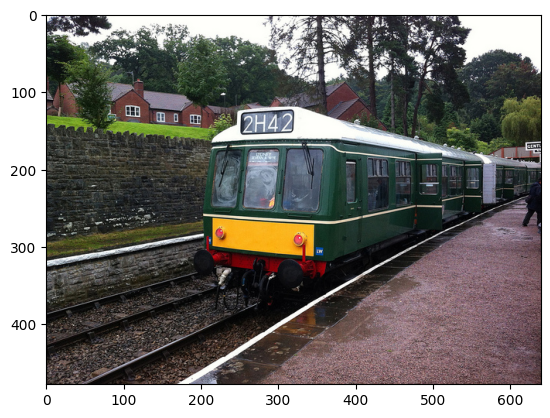

*****************************************
     Input: ['Some people sitting in the grass leaning against some wooden rest.']
 predicted: -,
V
TTTTTTTeTTenaTheTaTheTTheTheSixTheAAATheTheTheaAA
*****************************************

Step: 1001: train_loss=2.1366
Step: 1101: train_loss=2.1227
Step: 1201: train_loss=10.3451
Step: 1301: train_loss=2.1972
Step: 1401: train_loss=2.1877
Step: 1501: train_loss=15.2128
Step: 1601: train_loss=3.0112
Step: 1701: train_loss=2.4227
Step: 1801: train_loss=3.0468
Step: 1901: train_loss=2.4631


Validation: 0it [00:00, ?it/s]

*****************************************
     Input: ['An Japanese man telling a story to an American.']
 predicted: t,,,aThThaTaTT
TATheTheTheTheAAAAAAAThreeTheTwoOneAA
*****************************************

/kaggle/input/coco-2017-dataset/coco2017/train2017/000000342996.jpg


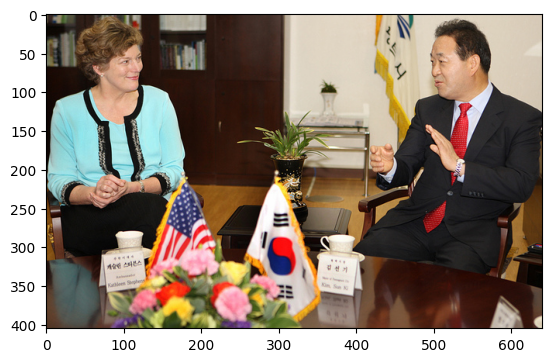

*****************************************
     Input: ['Some people sitting in the grass leaning against some wooden rest.']
 predicted: -,

s

TThreeThreeTheTheTheThreeaaaTheaTheTheTheThAAAThreeThreeThreeaAThree
*****************************************



OSError: [Errno 28] No space left on device

In [21]:
trainer = train_multimodal_gpt_model(multimodal_gpt_model, train_dataloader, val_dataloader, max_training_steps=max_training_steps)